# 画像生成 AI 入門: Python による拡散モデルの理論と実践
## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 22. Attend-and-Excite

Attend-and-Excite [[Chefer+ SIGGRAPH'23]](https://arxiv.org/abs/2301.13826) を用いて Stable Diffusion 等の生成モデルが苦手としている複数の物体や性質を指定しているプロンプトに対する忠実な画像生成を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [2]:
!nvidia-smi

Sun Jul 16 14:39:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [3]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.0 MB/s eta 0:00:00


## Attend-and-Excite を扱うパイプラインを構築

本セクションでは [`StableDiffusionAttendAndExcitePipeline`](https://huggingface.co/docs/diffusers/api/pipelines/attend_and_excite) を使用して Attend-and-Excite パイプラインの動作を確認します。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [4]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

今回もこれまで同様に事前学習済みモデルとして `runwayml/stable-diffusion-v1-5` を使用します。以下、素の Stable Diffusion と Attend-and-Excite による Stable Diffusion それぞれのパイプラインを読み込みます。

In [5]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionAttendAndExcitePipeline

model_id = "runwayml/stable-diffusion-v1-5"

#
# 素の Stable Diffusion (SD) の読み込み
#
pipe_sd = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe_sd = pipe_sd.to("cuda")

#
# Stable Diffusion をベースとした Attend & Excite (AE) の読み込み
#
pipe_ae = StableDiffusionAttendAndExcitePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe_ae = pipe_ae.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


入力するプロンプトと乱数の seed を指定します。今回はプロンプトとして Stable Diffusion が潜在的に苦手とする複数の物体の生成を指定してみます。

In [6]:
prompt = "A horse and a dog"
seed = 42

素の Stable Diffusion で画像を生成してみます。生成時に乱数の seed を固定することを忘れないようにします。

In [7]:
generator = torch.Generator().manual_seed(seed)

images_sd = pipe_sd(
    prompt,
    num_images_per_prompt=2,
    generator=generator
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Stable Diffusion で生成した画像を確認します。プロンプトとして `A horse and a dog` を指定しましたが、以下の画像ではどうでしょうか？

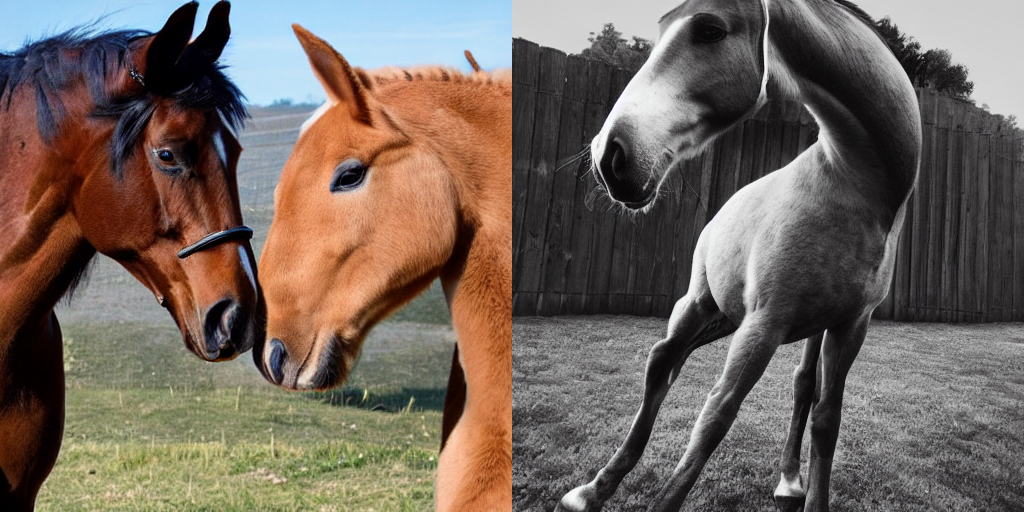

In [8]:
gen_result_sd = image_grid(images_sd, rows=1, cols=2)
gen_result_sd

次に Stable Diffusion を元にした Attend-and-Excite で画像を生成させてみます。

In [9]:
# `get_indices` 関数を使用して、対象のトークン（horse と dog）のインデックスを調べる
# 2 と 5 がそれぞれ horse と dog であることを確認
print(f"Indicies: {pipe_ae.get_indices(prompt)}")

# 上記で調べたトークンのインデックスを指定
token_indices = [2, 5]
generator = torch.Generator().manual_seed(seed)

# Attend-and-Excite パイプラインによって画像を生成
images_ae = pipe_ae(
    prompt,
    num_images_per_prompt=2,
    generator=generator,
    #
    # Additional arguments for Attend-and-Excite
    # 対象のトークンを指定
    #
    token_indices=token_indices,
).images

Indicies: {0: '<|startoftext|>', 1: 'a</w>', 2: 'horse</w>', 3: 'and</w>', 4: 'a</w>', 5: 'dog</w>', 6: '<|endoftext|>'}


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Attend-and-Excite で生成した画像を確認します。プロンプトとして `A horse and a dog` を指定しましたが、以下の画像ではどうでしょうか？正しく犬と馬が生成されているように見えます。

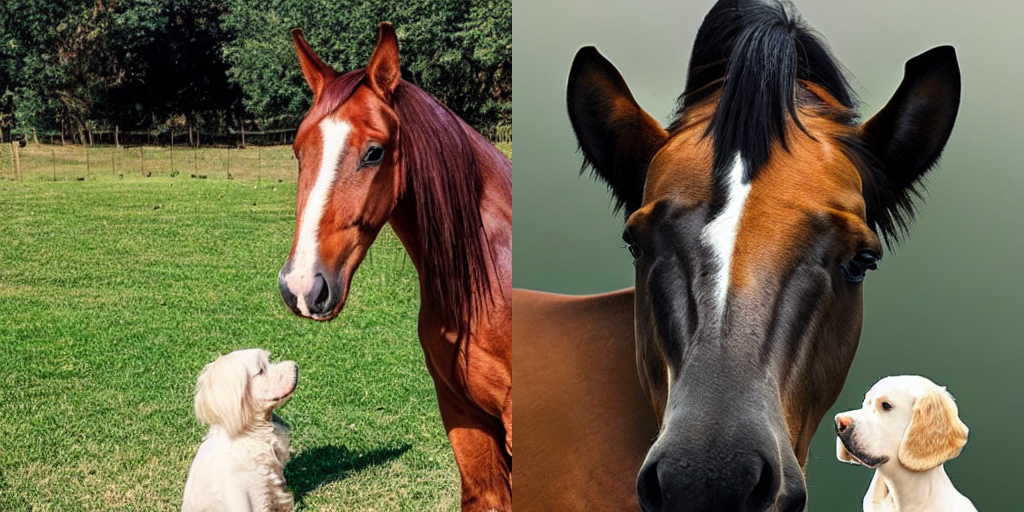

In [10]:
gen_result_ae = image_grid(images_ae, rows=1, cols=2)
gen_result_ae

最後に素の Stable Diffusion と Attend-and-Excite の生成結果を比較してみましょう。

Text(0.5, 1.0, 'Stable Diffusion with Attend-and-Excite')

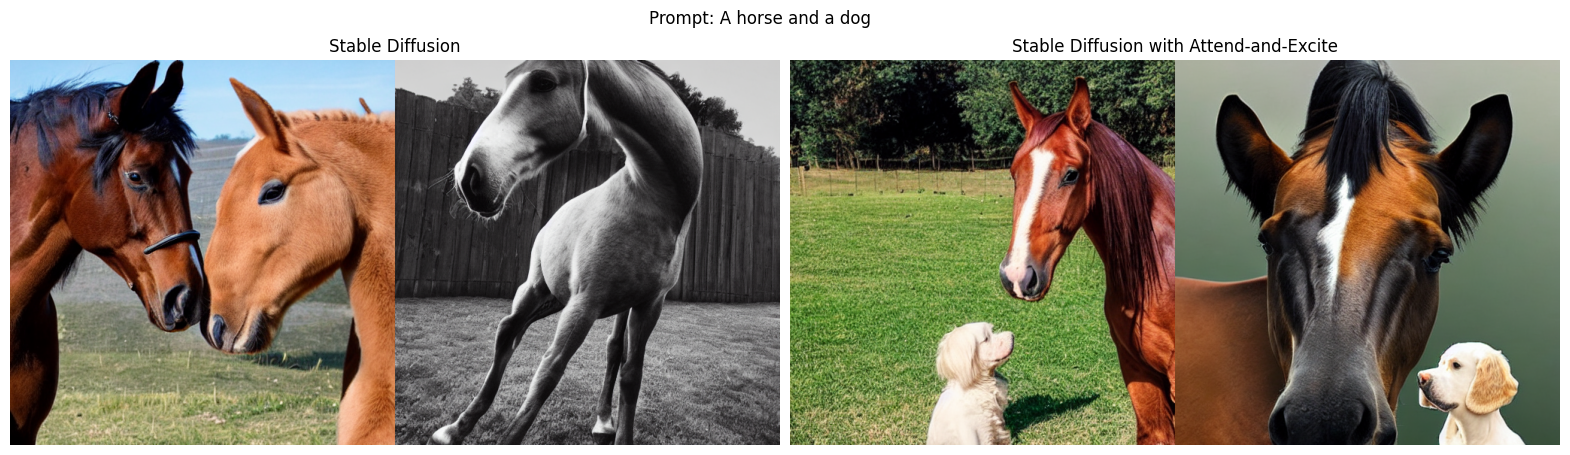

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 5))
grid = ImageGrid(
    fig,
    rect=111,
    nrows_ncols=(1, 2),
    axes_pad=0.1,
)

fig.suptitle(f"Prompt: {prompt}")

grid[0].imshow(gen_result_sd)
grid[0].axis("off")
grid[0].set_title("Stable Diffusion")

grid[1].imshow(gen_result_ae)
grid[1].axis("off")
grid[1].set_title("Stable Diffusion with Attend-and-Excite")